In [33]:
import custom_style; 
custom_style.style()

In [34]:
import os
import sys
import socket
if os.sys.platform == 'darwin':
    sys.path.append('/Users/j35/git/BraggEdge/python')
else:
    sys.path.append(r"C:\Users\user\Documents\GitHub\BraggEdge\python")
    sys.path.append(r"C:\Users\user\Anaconda3\envs\SNAP2016\lib\site-packages")
 
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets.widgets import interact
#from ipywidgets import widgets

from pprint import pprint

import datetime
import glob
import shutil
    
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge
from neutronbraggedge.material_handler.retrieve_material_metadata import RetrieveMaterialMetadata

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from ipywidgets import widgets
from IPython.display import display

import gui_widgets
import normalization
import load_handler

## USER INPUT

#### What is the distance source-detector  (m)?

In [37]:
distance_source_detector = 15.89

#### What is the detector offset (micros) ?

In [31]:
detector_offset = 4200  

#### Full list of material available:

In [9]:
retrieve_material = RetrieveMaterialMetadata(material = 'all')
list_returned = retrieve_material.full_list_material()
pprint(list_returned)

array(['C (diamond)', 'C (graphite)', 'Si', 'Ge', 'AlAs', 'AlP', 'AlSb',
       'GaP', 'GaAs', 'GaSb', 'inconel', 'InP', 'InAs', 'InSb', 'MgO',
       'SiC', 'CdS', 'CdSe', 'CdTe', 'ZnO', 'ZnS', 'PbS', 'PbTe', 'BN',
       'BP', 'CdS', 'ZnS', 'AlN', 'GaN', 'InN', 'LiF', 'LiCl', 'LiBr',
       'LiI', 'NaF', 'NaCl', 'NaBr', 'NaI', 'KF', 'KCl', 'KBr', 'KI',
       'RbF', 'RbCl', 'RbBr', 'RbI', 'CsF', 'CsCl', 'CsI', 'Al', 'Fe',
       'Ni', 'Cu', 'Mo', 'Pd', 'Ag', 'W', 'Pt', 'Au', 'Pb', 'TiN', 'ZrN',
       'HfN', 'VN', 'CrN', 'NbN', 'TiC', 'ZrC0.97', 'HfC0.99', 'VC0.97',
       'NC0.99', 'TaC0.99', 'Cr3C2', 'WC', 'ScN', 'LiNbO3', 'KTaO3',
       'BaTiO3', 'SrTiO3', 'CaTiO3', 'PbTiO3', 'EuTiO3', 'SrVO3', 'CaVO3',
       'BaMnO3', 'CaMnO3', 'SrRuO3', 'YAlO3'], dtype=object)


#### List of elements you want the Bragg Edges?     

ex: Li, Al, inconel

In [ ]:
list_of_elements = ['inconel']

#### How many Bragg Edges do you want to see?


In [38]:
number_of_bragg_edges = 8

### Retrieve Powder Bragg Edges 

In [39]:
_handler = BraggEdge(material=list_of_elements, 
                     number_of_bragg_edges = number_of_bragg_edges)
bragg_edges = _handler.bragg_edges
hkl = _handler.hkl

print(_handler)

Material: inconel
Lattice : 3.5950Å
Crystal Structure: FCC
Using local metadata Table: True
 h | k | l |	 d (Å)  |	 BraggEdge
---------------------------------------------
 1 | 1 | 1 |	 2.07557 |	 4.15115
 2 | 0 | 0 |	 1.79750 |	 3.59500
 2 | 2 | 0 |	 1.27102 |	 2.54205
 2 | 2 | 2 |	 1.03779 |	 2.07557
 3 | 1 | 1 |	 1.08393 |	 2.16787
 3 | 3 | 1 |	 0.82475 |	 1.64950
 3 | 3 | 3 |	 0.69186 |	 1.38372
 4 | 0 | 0 |	 0.89875 |	 1.79750



## Loading Data

In [ ]:
input_data_folder = '/Users/j35/data/notebooks_data/'

In [17]:
list_files = glob.glob(input_data_folder + "*.fits")

# remove from list *_SummedImg.fits fille
list_files = [file for file in list_files if not "_SummedImg.fits" in file] 

# =================================
# Automatically load and convert Time Spectra
# =================================
dir_name = os.path.dirname(list_files[0])

spectra_files_name = glob.glob(dir_name + '/*_Spectra.txt')
if spectra_files_name == []:
    print("Select Spectra File...")
    spectra_file = gui_widgets.gui_single_file(dir = default_dir)
else:
    spectra_file = spectra_files_name[0]

_tof_handler = TOF(filename = spectra_file)

_exp = Experiment(tof = _tof_handler.tof_array, 
                  distance_source_detector_m = distance_source_detector, 
                  detector_offset_micros = detector_offset)

lambda_array = _exp.lambda_array * 1e10 # to be in Angstroms
tof_array = _exp.tof_array

# =================================
# Load Data
# =================================

data = []
for _index, _file in enumerate(list_files):
    _image = load_handler.load_data(_file)
    data.append(_image)


### Crop Region

[320, 442, 20, 492]

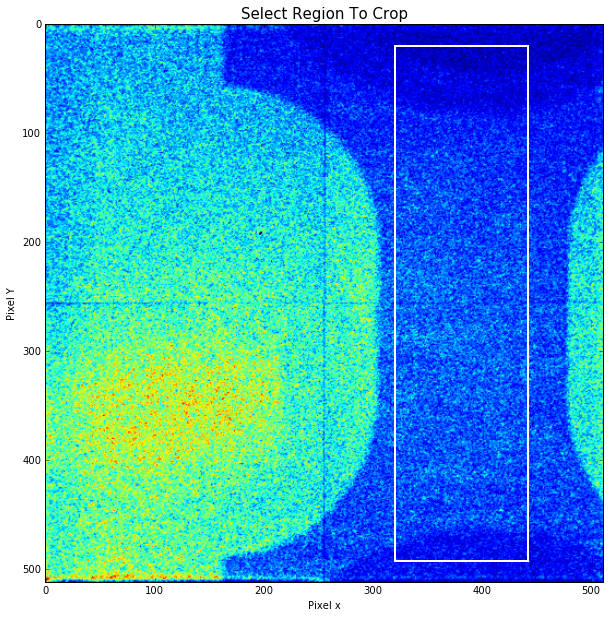

In [18]:
# =================================
# Crop Data
# =================================
[height, width] = data[0].shape

def plot_image_for_cropping(file_index, x_left, x_right, y_top, y_bottom):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_files)
crop = interact(plot_image_for_cropping,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='Image index'),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=20),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width-20),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=20), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-20))

In [19]:
# retrieve again powder bragg edges (in case number to display changed)
fig = tools.make_subplots(2, 1)

_handler = BraggEdge(material=list_of_elements, 
                     number_of_bragg_edges = number_of_bragg_edges)
bragg_edges = _handler.bragg_edges
hkl = _handler.hkl

[x_left, x_right, y_top, y_bottom] = crop.widget.result

sum_cropped_data = []
for _data in data:
    _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
    sum_cropped_data.append(_sum_data)
    
# format hkl labels
_hkl_formated = {}
for _material in hkl:
    _hkl_string = []
    for _hkl in hkl[_material]:
        _hkl_s = ",".join(str(x) for x in _hkl)
        _hkl_s = _material + "\n" + _hkl_s
        _hkl_string.append(_hkl_s)
    _hkl_formated[_material] = _hkl_string
    
trace = go.Scatter(
    x = lambda_array,
    y = sum_cropped_data,
    mode = 'markers')

trace2 = go.Scatter(
    x = tof_array,
    y = sum_cropped_data,
    mode = 'markers')

layout = go.Layout(
    width = "100%",
    height = 500,
    title = "Sum Counts vs TOF",
    xaxis = dict(
        title = "Lambda (Angstroms)"
                ),
    yaxis = dict(
        title = "Sum Counts"
                ),
    )

max_x = 6
y_off = 1

for y_index, _material in enumerate(bragg_edges):
    for _index, _value in enumerate(bragg_edges[_material]):
        if _value > max_x:
            continue
        bragg_line = {"type": "line",
                    'x0': _value,
                    'x1': _value,
                     'yref': "paper",
                     'y0': 0,
                     'y1': 1,
                     'line': {
                        'color': 'rgb(255, 0, 0)',
                        'width': 1
            }}
        layout.shapes.append(bragg_line)
        y_off = 1 - 0.25 * y_index
    
        # add labels to plots
        _annot = dict(
                    x=_value,
                    y= y_off,
                    text = _hkl_formated[_material][_index],
                    yref="paper",
                    font=dict(
                        family="Arial",
                        size=12,
                        color="rgb(150,50,50)"
                    ),
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-25)
                
        layout.annotations.append(_annot)
        
#figure = tools.make_subplots(rows=2, cols=1)
#figure.append_trace(trace, 1, 1)
#figure.append_trace(trace2, 2, 1)
#figure.layout = layout

data1 = [trace]
def plot_final_image(x_left, x_right, y_top, y_bottom):
    layout.xaxis.range = [x_left, x_right]
    layout.yaxis.range = [y_bottom, y_top]
    figure = go.Figure(data=data1, layout=layout)
    iplot(figure)

resize = interact(plot_final_image,
        x_left = widgets.FloatSlider(min=lambda_array[0], max=lambda_array[-1], 
                                     description = 'Lambda min (Angstroms)',
                                     step=0.01, value=lambda_array[0]),
        x_right = widgets.FloatSlider(min=lambda_array[0], max=lambda_array[-1], 
                                      description = 'Lambda max (Angstroms)',
                                      step=0.01, value=lambda_array[-1]),
        y_top = widgets.FloatSlider(min=np.min(sum_cropped_data), max=max(sum_cropped_data),
                                        description = 'Max Counts',
                                       step=0.01, value=np.max(sum_cropped_data)),
        y_bottom = widgets.FloatSlider(min=np.min(sum_cropped_data), max=max(sum_cropped_data),
                                        description = 'Min Counts',
                                       step=0.01, value=np.min(sum_cropped_data)))
